In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import drange
import datetime
import pyhht
import emd
from scipy.signal import hilbert
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from scipy.io import loadmat

import plotly.express as px

# to filter(remove) the warnings
import warnings
warnings.filterwarnings('ignore')

data_sbi = pd.read_excel("final_SBIN_18-7_to_16-9-2022.xlsx")
data_axis = pd.read_excel("final_AXISBANK_18-7_to_16-9-2022.xlsx")
data_hdfc = pd.read_excel("final_HDFCBANK_18-7_to_16-9-2022.xlsx")
data_icici = pd.read_excel("final_ICICIBANK_18-7_to_16-9-2022.xlsx")

In [2]:
n = int(input('\nEnter the number of datasets/banks you want to enter the data for: '))

data_list = []
stock_names_list=[]
    
for i in range(n):
    stock_names_list.append(input('\nEnter the Name of the Dataset {}  '.format(i+1)))
    f_path = input('\n(file should be in excel)\nEnter the path of the file: \n')
    data_list.append(pd.read_excel(f_path))



Enter the number of datasets/banks you want to enter the data for: 4

Enter the Name of the Dataset 1  SBI

(file should be in excel)
Enter the path of the file: 
final_SBIN_18-7_to_16-9-2022.xlsx

Enter the Name of the Dataset 2  AXIS BANK

(file should be in excel)
Enter the path of the file: 
final_AXISBANK_18-7_to_16-9-2022.xlsx

Enter the Name of the Dataset 3  HDFC BANK

(file should be in excel)
Enter the path of the file: 
final_HDFCBANK_18-7_to_16-9-2022.xlsx

Enter the Name of the Dataset 4  ICICI BANK

(file should be in excel)
Enter the path of the file: 
final_ICICIBANK_18-7_to_16-9-2022.xlsx


In [3]:
df_close_list = []
# setting the INDEX of the DataFrame & Creating the CLOSE DataFrames
for i in range(len(data_list)):
    if 'Time' in data_list[i].columns:
        data_list[i].set_index(['Date','Time'],inplace=True)
        df_close_list.append(data_list[i])
        df_close_list[i] = pd.DataFrame( data_list[i].Close , index = data_list[i].index )
    elif 'Time' not in data_list[i].columns:
        data_list[i].set_index(['Date'],inplace=True)
        df_close_list.append(data_list[i])
        df_close_list[i] = pd.DataFrame( data_list[i].Close , index = data_list[i].index )


#Plotting all the Closing Price curves

#for i in range(len(df_close_list)):
    #df_close_list[i].plot(title = stock_names_list[i])

## EMD functions

In [4]:
def EMD_SVR( X_train , y_train , X_test , y_test , i:int):
        
        comp_val = []
            # SVR
        #print('\nSVR for rbf kernel going on....\n')
        svr_rbf = SVR( kernel='rbf' )   # rbf
        #print('\nmodel made')
        svr_rbf_model = svr_rbf.fit ( X_train , y_train )
        #print('\nmodel trained')
        svr_rbf_score = svr_rbf.score ( X_test , y_test )
        comp_val.append(svr_rbf_score)
        
        #print('\nSVR for linear kernel going on....\n')
        #svr_linear = SVR( kernel='linear' )
        #print('\nmodel made')
        #svr_linear_model = svr_linear.fit ( X_train , y_train )
        #print('\nmodel trained')
        #svr_linear_score = svr_linear.score ( X_test , y_test )
        #comp_val.append(svr_linear_score)
        
        #print('\nSVR for polynomial kernel going on....\n')
        svr_poly = SVR( kernel='poly' )
        #print('\nmodel made')
        svr_poly_model = svr_poly.fit ( X_train , y_train )
        #print('\nmodel trained')
        svr_poly_score = svr_poly.score ( X_test , y_test )
        comp_val.append(svr_poly_score)
        
        print('\n\n ------- for {} ------>>>>\n'.format(stock_names_list[i]))
        
        cv_ind = comp_val.index(max(comp_val))
        if cv_ind == 0:
            y_pred = svr_rbf.predict(X_test) # for the predicted values of X_test, we can compare the y_pred & y_test to see the error/accuracy
            # to see the just NEXT Value ->
            X_test_sorted = X_test.sort_values(by=['Date','Time'])
            last = X_test_sorted.iloc[-1]
            EMD_SVR.y_just_next_val = svr_rbf.predict([last])[0]   
            mse = mean_squared_error ( y_test , y_pred )  # MSE b/w actual and predicted values
            rmse = np.sqrt( mse )
            print('By SVR,(kernel - > RBF) we are getting model accuracy of {}.\nfor the test set, the MSE = {} & RMSE = {}.\nby SVR (rbf) --->  we get the just next predicted value as : {}\n'.format(comp_val[cv_ind] , mse , rmse , EMD_SVR.y_just_next_val))
            
            
        #elif cv_ind == 1:
            #y_pred = svr_linear.predict(X_test) # for the predicted values of X_test, we can compare the y_pred & y_test to see the error/accuracy
            # to see the just NEXT Value ->
            #X_test_sorted = X_test.sort_values(by=df_close_list[0].index.values)
            #X_test_sorted = X_test.sort_values(by=['Date','Time'])
            #last = X_test_sorted.iloc[-1]
            #y_just_next_val = svr_rbf.predict([last])[0]  
            #mse = mean_squared_error ( y_test , y_pred )  # MSE b/w actual and predicted values
            #rmse = np.sqrt( mse )
            #print('\n\nBy SVR,(kernel - > LINEAR) we are getting accuracy of {}.\nSo, using this model, we predict the just next value & we get:  {}\n & for the test set, the MSE = {} & RMSE = {}'.format(comp_val[cv_ind] , y_just_next_val , mse , rmse))
        
        elif cv_ind == 1:
            y_pred = svr_poly.predict(X_test) # for the predicted values of X_test, we can compare the y_pred & y_test to see the error/accuracy
            # to see the just NEXT Value ->
            X_test_sorted = X_test.sort_values(by=['Date','Time'])
            last = X_test_sorted.iloc[-1]
            EMD_SVR.y_just_next_val = svr_rbf.predict([last])[0]  
            mse = mean_squared_error ( y_test , y_pred )  # MSE b/w actual and predicted values
            rmse = np.sqrt( mse )
            print('By SVR,(kernel - > POLYNOMIAL) we are getting model accuracy of {}.\nfor the test set, the MSE = {} & RMSE = {}.\nby SVR (poly) --->  we get the just next predicted value as :  {}\n'.format(comp_val[cv_ind] , mse , rmse , EMD_SVR.y_just_next_val))
            
        
        del svr_rbf , svr_rbf_model , svr_rbf_score
        #del svr_linear , svr_linear_model , svr_linear_score
        del svr_poly , svr_poly_model , svr_poly_score
        del X_train, y_train , X_test , y_test
        del comp_val

In [13]:
def EMD_DTR( X_rte1_train , y_rte1_train , X_rte1_test , y_rte1_test ):
    
    DTR = DecisionTreeRegressor (random_state = 0)
    DTR.fit( X_rte1_train , y_rte1_train )
    y_rte1_pred = DTR.predict((X_rte1_test))
    r_sq = metrics.r2_score( y_rte1_test , y_rte1_pred )
    mse = mean_squared_error ( y_rte1_test , y_rte1_pred )
    rmse = np.sqrt(mse)
    print("\nBy DTR(Decision Tree Regressor), we're getting model accuracy of {}\n& MSE = {}   ,   RMSE = {}".format(r_sq , mse , rmse))
    
    X_rte1_test_sorted = X_rte1_test.sort_values(by=['Date','Time'])
    last_dtr = X_rte1_test_sorted.iloc[-1]
    EMD_DTR.y_just_next_val_dtr = DTR.predict([last_dtr])[0]
    print('by DTR --->  we get the just next predicted value as : {}\n'.format(EMD_DTR.y_just_next_val_dtr))
    
    
    
    
    del DTR
    del X_rte1_train , y_rte1_train , X_rte1_test , y_rte1_test
    del y_rte1_pred , mse , rmse

# 5, 2, 2 -> Build_model
model_f522 = ARIMA(train , order=(5,2,2))
fit522 = model_f522.fit()
print(fit522.summary())

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fit522.forecast(20, alpha=0.05) , label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot ( y_rte1_train, label='training')
    plt.plot( y_rte1_test, label='actual')
    plt.plot(DTR.forecast(20) , label='forecast')

    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [14]:
#features -> IMF
list_next_IMF_SVR = []
list_next_IMF_DTR = []   

#features -> IMF, hilbert(IMF)
list_next_IMF_hil_SVR = []
list_next_IMF_hil_DTR = [] 

#features -> IMF, IF
list_next_IMF_IF_SVR = []
list_next_IMF_IF_DTR = []   

#features -> IMF, IA
list_next_IMF_IA_SVR = []
list_next_IMF_IA_DTR = []  

#features -> IMF, IF, IA 
list_next_IMF_IF_IA_SVR = []
list_next_IMF_IF_IA_DTR = [] 

#features -> IMF, hil, IF, IA 
list_next_IMF_hil_IF_IA_SVR = []
list_next_IMF_hil_IF_IA_DTR = [] 



In [20]:
def byEMD( list_df_close : list ):  
    
    
    #   Decompose each input signal into IMFs.
    
    IMFs_list = []
    i=0
    while i < len(list_df_close):
        #IMFs_i = pyhht.emd.EMD( x = list_df_close[i].Close )
        #IMFs_i_decomposed = IMFs_i.decompose()
        IMFs_list.append( (pyhht.emd.EMD( x = list_df_close[i].Close )).decompose() )
        i+=1
    
    #print("\nDecomposition done!\n\n", IMFs_list)
    
  
    #  Reconstruction via all IMFs, last 5 IMFs, last 3IMFs
    
    df_close_recons_list = []
    df_close_recons_last5_list = []
    df_close_recons_last3_list = []
    
    i=0
    while i < len(IMFs_list):
        
        xt=0
        for j in IMFs_list[i]:
            xt=xt+j                         # x(t)  is our original signal i.e, Closing Price signal
        df_close_recons_list.append(pd.DataFrame ( xt , index = list_df_close[i].index , columns = ['Close'] ))
   
        xtlast5 = 0
        xtlast3=0
        for k in range(1 , len(IMFs_list[i])+1):
            if k<6:
                xtlast5 = xtlast5 + IMFs_list[i][-k]
            if k<4:
                xtlast3 = xtlast3 + IMFs_list[i][-k]
        
        df_close_recons_last5_list.append( pd.DataFrame ( xtlast5 , index = list_df_close[i].index , columns = ['Close (from last 5 components)'] ) )
        df_close_recons_last3_list.append(  pd.DataFrame ( xtlast3 , index = list_df_close[i].index , columns = ['Close (from last 3 components)'] ) )
        i+=1
    
        #print("\n\n\nReconstruction done!")
    #print('\n\n\ndf_close_recons List:  -----\n')
    #for i in range(n):
        #print('\n--------------',stock_names_list[i],' --------------\n', df_close_recons_list[i] ,'\n\n')
        
    # PLOTTING Recons vs Original --->>>
    
    for i in range(n):
        print('\n\n   Plotting of  {}\n'.format(stock_names_list[i]))
        list_df_close[i]['Close'].plot(label="Original Closing Price of {}".format(stock_names_list[i]))
        df_close_recons_list[i]['Close'].plot(label='Reconstruction by all components of {}'.format(stock_names_list[i]))
        df_close_recons_last5_list[i]['Close (from last 5 components)'].plot(label='Reconstruction by LAST 5 components of {}'.format(stock_names_list[i]))
        df_close_recons_last3_list[i]['Close (from last 3 components)'].plot(label='Reconstruction by LAST 3 components of {}'.format(stock_names_list[i]))
        plt.legend()
        plt.show()
   

    # IMF Dataframe
    
    #print('\n\n\n\n\n\n-------- IMFs DataFrame ------->>>\n\n')
    
    IMFs_df_list = []
    
    i=0
    while i < len(IMFs_list):
        col=[]
        for a in range(len(IMFs_list[i])):
            col.append('IMF {}'.format(a+1))

        IMF_i_df = pd.DataFrame ( IMFs_list[i].transpose() , index = list_df_close[i].index , columns = col )
        IMFs_df_list.append(IMF_i_df)
        i+=1
    
    #for i in IMFs_df_list:
        #print(i,'\n\n')
    #print('\n\nIMFS DataFrames formed!')
    
    
    
    # PLOTTING the IMFs
    
    print('\n\n Plotting the IMFs')
    for i in range(n):
        IMFs_df_list[i].plot(title=stock_names_list[i])
    plt.show()
    
    # IP ,IF , IA ---> of the IMFs
    
    IP_list = []
    IF_list = []
    IA_list = []
    
    IE_list = []
    
    sample_rate = 1
    for i in range(n):
        IP, IF, IA = emd.spectra.frequency_transform( IMFs_list[i] , sample_rate, 'hilbert')
        IP_list.append(IP)
        IF_list.append(IF)
        IA_list.append(IA)
        #Instantaneous Energy of j-th component ----->  Ej (t) = |aj (t)|^2
        IE_list.append(np.square(IA))
    
    #print('\n\n IF, IA, IP of the IMFs and IEs found!')
    
    
    # IF & IA and IE DataFrames
    
    IFs_df_list = []
    IAs_df_list = []
    
    IEs_df_list = []
    


    i=0
    while i < len(IF_list):
        #print('\n\n-------IF & IA dataframes of {} signal'.format(stock_names_list[i]))
        col_IF = []
        col_IA = []
        col_IE = []
        for a in range(len(IF_list[i])):
            col_IF.append('IF of the IMF {}'.format(a+1))
            col_IA.append('IA of the IMF {}'.format(a+1))
            col_IE.append('IE of the IMF {}'.format(a+1))
        IF_i_df = pd.DataFrame ( IF_list[i].transpose() , index = list_df_close[i].index , columns = col_IF )
        IFs_df_list.append(IF_i_df)
        IA_i_df = pd.DataFrame ( IA_list[i].transpose() , index = list_df_close[i].index , columns = col_IA )
        IAs_df_list.append(IA_i_df)
        IE_i_df = pd.DataFrame ( IE_list[i].transpose() , index = list_df_close[i].index , columns = col_IE )
        IEs_df_list.append(IE_i_df)
        i+=1
        
    # PLOTIING IFs and IAs
    
    print('\n\n\n Plotting IFs & IAs of the IMFs---->\n\n\n')
    
    for i in range(n):
        IFs_df_list[i].plot(subplots=True , figsize=(14,11))
        plt.suptitle("\nInstantaneous Frequency vs Date of {}\n".format(stock_names_list[i]) , fontsize=15)
        
        IAs_df_list[i].plot(subplots=True , figsize=(14,11))
        plt.suptitle("\nInstantaneous Amplitude vs Date of {}\n\n\n".format(stock_names_list[i]) , fontsize=15)
        
        plt.tight_layout()
        plt.show()
        
    # PLOTTING the IEs --->
    
    # finding the Means :::
    IF_mean_IMF_df_list = []
    IE_mean_IMF_df_list = []
    
    for i in range(n):
        mean_IF_list = []
        ind_IF = []
        mean_IE_list = []
        ind_IE = []
        for j in range(len(IMFs_df_list[i].columns)):
            mean_IF_list.append(IFs_df_list[i].iloc[:,j].mean())
            ind_IF.append('mean of IF {}'.format(j+1))
    
            mean_IE_list.append(IEs_df_list[i].iloc[:,j].mean())
            ind_IE.append('mean of IE {}'.format(j+1))
        # dataframes created --> 
        IF_mean_IMF_df_list.append(pd.DataFrame ( mean_IF_list , index = ind_IF , columns = ['Mean of IFs of the i-th IMF']))
        IE_mean_IMF_df_list.append(pd.DataFrame ( mean_IE_list , index = ind_IE , columns = ['Mean of IEs of the i-th IMF']))
        
    #print('\n Mean dataframes created!\n')
    
    print('\n\nInstantaneous Energy - Frequency Spectrum & Mean of the clusters:::--> \n')
    for i in range(n):
        
        figure(figsize=(9, 7), dpi=70)
        leg_list = []
        
        for j in range(len(IMFs_df_list[i].columns)):
            leg_list.append('IMF mode {}'.format(j+1))
            plt.scatter(x = IFs_df_list[i].iloc[:,j] , y = IEs_df_list[i].iloc[:,j] )
        
        leg_list.append('mean of each cluster')
        plt.scatter( IF_mean_IMF_df_list[i]['Mean of IFs of the i-th IMF'] , IE_mean_IMF_df_list[i]['Mean of IEs of the i-th IMF']  , marker = "X" , c='k' )

        ##obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit( IF_mean_IMF_df_list[i]['Mean of IFs of the i-th IMF'] , IE_mean_IMF_df_list[i]['Mean of IEs of the i-th IMF']  ,  1  )
        # Regression line
        plt.plot( IF_mean_IMF_df_list[i]['Mean of IFs of the i-th IMF']  , (m* ( IF_mean_IMF_df_list[i]['Mean of IFs of the i-th IMF'] )) +b  , color='k')

        plt.legend( leg_list , loc='best')

        plt.xlabel("Instantaneous Frequency f(t)" , fontsize=12)
        plt.ylabel("Instantaneous Energy E(t)" , fontsize=12)
        plt.title("\n{} ---> Instantaneous Energy-Frequency Spectrum & Mean of the cluster\n\n".format(stock_names_list[i]) , fontsize=20)

        plt.tight_layout()
        plt.show()
        
    
    
    
    
    ### IMF - Close DataFrame -------->
    
    IMF_df_close_list = []
    IMF_close_df = []
    
    print('\n\nfor only IMFs as features -> \n')
    
    for i in range(4):
        
        comp_val = []
        
        IMF_close_df.append(IMFs_df_list[i].join(list_df_close[i].Close))
        IMF_df_close_list.append(IMF_close_df[i])
        
        X = IMF_close_df[i].drop('Close',axis=1)
        y = IMF_close_df[i]['Close']
        # TRAIN - TEST split
        X_train , X_test , y_train , y_test = train_test_split ( X , y , test_size=0.2 , random_state = 0 , shuffle=False )
        print(X_train)
        print('\nX test :\n',X_test)
        
        
        # SVR
        EMD_SVR( X_train , y_train , X_test , y_test , i )
        # DTR
        EMD_DTR( X_train , y_train , X_test , y_test )
        
        #appending the just next valu in the global list
        list_next_IMF_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_DTR.append(EMD_DTR.y_just_next_val_dtr)
    
    
    ### IMF -  hilbert(IMF) - Close DataFrames -------->
    
    IMF_trans_list = []
    IMF_trans_hilbert_list = []
    IMF_trans_hilbert_df_list = []
    IMF_hil_df_list = []
    
    print('\n\nfor IMFs , hil(IMFs) as features\n')
    
    for i in range(n):   

        IMF_trans_list.append(IMFs_list[i].transpose())
        IMF_trans_hilbert_list.append(abs(hilbert(IMF_trans_list[i])))
        # hilbert df
        col_hil=[]
        for a in range(len(IMFs_list[i])):
            col_hil.append('hilbert of IMF {}'.format(a+1))
        IMF_trans_hilbert_df_list.append( pd.DataFrame ( IMF_trans_hilbert_list[i], index = list_df_close[i].index , columns = col_hil ) )
        
        IMF_df_copy = IMFs_df_list[i].copy(deep=True)
        colname = np.array(IMF_trans_hilbert_df_list[i].columns)    # getting all the column names of the hilbert-df in an array/list
        j=0
        for b in range(2*len(IMFs_list[i])):  
            if b%2!=0:
                vals = IMF_trans_hilbert_df_list[i].iloc[:,j].values

                IMF_df_copy.insert(b ,(colname[j]) ,vals)
                j+=1
        IMF_hil_df_list.append( IMF_df_copy.join(list_df_close[i].Close) )
        
        X1 = IMF_hil_df_list[i].drop('Close',axis=1)
        y1 = IMF_hil_df_list[i]['Close']
        # TRAIN - TEST split
        X1_train , X1_test , y1_train , y1_test = train_test_split ( X1 , y1 , test_size=0.2 , random_state = 0 , shuffle=False )
        
        EMD_SVR( X1_train , y1_train , X1_test , y1_test , i )
        EMD_DTR( X1_train , y1_train , X1_test , y1_test )
        
        #appending the just next valu in the global list
        list_next_IMF_hil_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_hil_DTR.append(EMD_DTR.y_just_next_val_dtr)
        
        
        
        
    ### IMF - IF dataframes --------->
    
    IMF_IF_df_list = []
    
    print('\n\nfor IMFs , IFs as features\n')
    
    for i in range(n):
        
        IMF_df_copy1 = IMFs_df_list[i].copy(deep=True)   # creating a deep copy of IMF_df
        colname1 = np.array(IFs_df_list[i].columns)      # getting Column Names of IF_df
        j=0
        for b in range(2*len(IMFs_list[i])):
            if b%2!=0:
                val = IFs_df_list[i].iloc[:,j].values

                IMF_df_copy1.insert(b ,(colname1[j]) ,val)
                j+=1
        IMF_IF_df_list.append( IMF_df_copy1.join(list_df_close[i].Close) )      # IMF-IF dataframe
        
        X2 = IMF_IF_df_list[i].drop('Close',axis=1)   #IMFs & IFs
        y2 = IMF_IF_df_list[i]['Close']               # Closing Price
        # TRAIN - TEST split
        X2_train , X2_test , y2_train , y2_test = train_test_split ( X2 , y2 , test_size=0.2 , random_state = 0 , shuffle=False )
        
        EMD_SVR( X2_train , y2_train , X2_test , y2_test , i )
        EMD_DTR( X2_train , y2_train , X2_test , y2_test )
        
        #appending the just next valu in the global list
        list_next_IMF_IF_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_IF_DTR.append(EMD_DTR.y_just_next_val_dtr)
        
        
        
        
        
    ### IMF - IA dataframes --------->
    
    IMF_IA_df_list =[]
    
    print('\n\nfor IMFs , IAs as features\n')
    print(i)
    for i in range(n):
        
        IMF_df_copy2 = IMFs_df_list[i].copy(deep=True)   # creating a deep copy of IMF_df
        colname2 = np.array(IAs_df_list[i].columns)      # getting Column Names of IA_df
        j=0
        for b in range(2*len(IMFs_list[i])):
            if b%2!=0:
                val = IAs_df_list[i].iloc[:,j].values

                IMF_df_copy2.insert(b ,(colname2[j]) ,val)
                j+=1
        IMF_IA_df_list.append( IMF_df_copy2.join(list_df_close[i].Close) )      # IMF-IA dataframe
        
        X3 = IMF_IA_df_list[i].drop('Close',axis=1)   #IMFs & IAs
        y3 = IMF_IA_df_list[i]['Close']               # Closing Price
        # TRAIN - TEST split
        X3_train , X3_test , y3_train , y3_test = train_test_split ( X3 , y3 , test_size=0.2 , random_state = 0 , shuffle=False )
        
        EMD_SVR( X3_train , y3_train , X3_test , y3_test , i )
        EMD_DTR( X3_train , y3_train , X3_test , y3_test )
        
        #appending the just next valu in the global list
        list_next_IMF_IA_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_IA_DTR.append(EMD_DTR.y_just_next_val_dtr)
        
        
        
    ### IMF - IF -IA dataframes ---------->
    
    IMF_IF_IA_df_list = []
    
    print('\n\nfor IMFs , IFs , IAs as features\n')
    
    for i in range(n):
        
        IMF_IF_noCls_df_copy = IMF_IF_df_list[i].drop('Close',axis=1)
        IMF_IF_df_copy = IMF_IF_noCls_df_copy.copy (deep=True)   # creating a deep copy of IMF_IF_df   # IMF_df_copy1 has IMFs-IFs
        colname_IA = np.array(IAs_df_list[i].columns)          # getting all column names of IA_df
        
        collist = []
        for c in range( 1,len(IMFs_list[i])+1 ):
            res = (2*c)+(c-1)
            collist.append(res)
            
        j=0
        for b in collist :                 # 24 columns + 12columns = 36 columns
            val_IA = IAs_df_list[i].iloc[:,j].values

            IMF_IF_df_copy.insert( b , (colname_IA[j]) , val_IA )
            j+=1
        
        IMF_IF_IA_df_list.append( IMF_IF_df_copy.join(list_df_close[i].Close) )      # IMF-IF-IA dataframe
        
        X4 = IMF_IF_IA_df_list[i].drop('Close',axis=1)   #IMFs & IFs & IAs
        y4 = IMF_IF_IA_df_list[i]['Close']               # Closing Price
        # TRAIN - TEST split
        X4_train , X4_test , y4_train , y4_test = train_test_split ( X4 , y4 , test_size=0.2 , random_state = 0 , shuffle=False)

        EMD_SVR( X4_train , y4_train , X4_test , y4_test , i )
        EMD_DTR( X4_train , y4_train , X4_test , y4_test )
        
        #appending the just next valu in the global list
        list_next_IMF_IF_IA_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_IF_IA_DTR.append(EMD_DTR.y_just_next_val_dtr)
        
        
        
        
    ### IMF - abs( hilbert(IMF) ) - IF - IA  dataframes --------->
    
    IMF_hil_IF_IA_df_list = []
    
    print('\n\nfor IMFs , hil(IMFs) , IFs , IAs as features\n')
    
    for i in range(n):
        
        IMF_hil_noCls_df_copy = IMF_hil_df_list[i].drop('Close',axis=1)
        df_copy = IMF_hil_noCls_df_copy.copy(deep=True)

        cols_IF = np.array(IFs_df_list[i].columns)
        cols_IA = np.array(IAs_df_list[i].columns)
        
        collist_IF = []
        collist_IA = []
        
        res_IF = 2
        res_IA = 3
        for c in range( 1 , (len(IMFs_list[i])+1) ):
            collist_IF.append(res_IF)
            res_IF+=4
            collist_IA.append(res_IA)
            res_IA+=4

        j=0
        for a in collist_IF:      # index --> 2,6,10,14,...,30,34,...,46  --- 12 columns indices
            vals_IF = IFs_df_list[i].iloc[:,j].values
            vals_IA = IAs_df_list[i].iloc[:,j].values
            df_copy.insert( a , cols_IF[j] , vals_IF )
            df_copy.insert( a+1 , cols_IA[j], vals_IA )
            j+=1

        IMF_hil_IF_IA_df_list.append( df_copy.join(list_df_close[i].Close) )  # IMF-hil_IF_IA dataframe
        
        X5 = IMF_hil_IF_IA_df_list[i].drop('Close',axis=1)   #IMFs & abs(hilbert(IMFs)) & IFs & IAs
        y5 = IMF_hil_IF_IA_df_list[i]['Close']               # Closing Price
        # TRAIN - TEST split
        X5_train , X5_test , y5_train , y5_test = train_test_split ( X5 , y5 , test_size=0.2 , random_state = 0 , shuffle=False )
        print('\n\ntrain-test split.......\n')
        EMD_SVR( X5_train , y5_train , X5_test , y5_test , i )
        EMD_DTR( X5_train , y5_train , X5_test , y5_test )
        
        #appending the just next value in the global list
        list_next_IMF_hil_IF_IA_SVR.append(EMD_SVR.y_just_next_val)
        list_next_IMF_hil_IF_IA_DTR.append(EMD_DTR.y_just_next_val_dtr)
        
        
        
    ### ---------------------------------------------------------------------------------------------------------------------
    

In [21]:
def resultEMD_bySVR(actual_just_next_val_list:list):
    print('\n By EMD & SVR model, we got:----------------------------------\n')
    list_EMD_feature_set = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA' , 'Original NEXT value' ]
    df_next_IMF_SVR_ori = pd.DataFrame( data = [ list_next_IMF_SVR , list_next_IMF_hil_SVR , list_next_IMF_IF_SVR , list_next_IMF_IA_SVR , list_next_IMF_IF_IA_SVR , list_next_IMF_hil_IF_IA_SVR , actual_just_next_val_list ] , index = [list_EMD_feature_set] , columns =[stock_names_list] ) #, name = 'Next price PREDICTION by features-"IMF, IMF-hil(IMF), etc."' )
    df_next_IMF_SVR_ori = df_next_IMF_SVR_ori.apply(pd.to_numeric) # to convert all columns values into numeric values

    svr_list_acc_f1=[]
    svr_list_acc_f2=[]
    svr_list_acc_f3=[]
    svr_list_acc_f4=[]
    svr_list_acc_f5=[]
    svr_list_acc_f6=[]

    for i in range(n):

        ori_svr = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i] # for original prices of SBI -> AXIS -> ...

        # for features - IMFs
        svr_pred_f1 = df_next_IMF_SVR_ori.iloc[0:1].iloc[0].iloc[i]
        svr_acc_f1 = (1 - (abs(ori_svr - svr_pred_f1)/ori_svr))*100
        svr_list_acc_f1.append(svr_acc_f1)

        #for features - IMFs, hil(IMFs)
        svr_pred_f2 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
        svr_acc_f2 = (1 - (abs(ori_svr - svr_pred_f2)/ori_svr))*100
        svr_list_acc_f2.append(svr_acc_f2)

        #for features - IMFs, IFs
        svr_pred_f3 = df_next_IMF_SVR_ori.iloc[2:3].iloc[0].iloc[i]
        svr_acc_f3 = (1 - (abs(ori_svr - svr_pred_f3)/ori_svr))*100
        svr_list_acc_f3.append(svr_acc_f3)

        #for features - IMFs, IAs
        svr_pred_f4 = df_next_IMF_SVR_ori.iloc[3:4].iloc[0].iloc[i]
        svr_acc_f4 = (1 - (abs(ori_svr - svr_pred_f4)/ori_svr))*100
        svr_list_acc_f4.append(svr_acc_f4)

        #for features - IMFs, IFs, IAs
        svr_pred_f5 = df_next_IMF_SVR_ori.iloc[4:5].iloc[0].iloc[i]
        svr_acc_f5 = (1 - (abs(ori_svr - svr_pred_f5)/ori_svr))*100
        svr_list_acc_f5.append(svr_acc_f5)

        #for features - IMFs, hil(IMFs), IFs, IAs
        svr_pred_f6 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
        svr_acc_f6 = (1 - (abs(ori_svr - svr_pred_f6)/ori_svr))*100
        svr_list_acc_f6.append(svr_acc_f6)
        
    df_EMD_SVR_acc = pd.DataFrame(data = [svr_list_acc_f1 , svr_list_acc_f2 , svr_list_acc_f3 , svr_list_acc_f4 , svr_list_acc_f5 , svr_list_acc_f6] , index = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA'] , columns = [stock_names_list])
    print('\nJust the Next price:-\n',df_next_IMF_SVR_ori)
    print('\n\n\nAbsolute Accuracy (b/w just the next price & the original price) :-\n',df_EMD_SVR_acc)
    
    df_next_IMF_SVR_ori = df_next_IMF_SVR_ori.apply(pd.to_numeric) # convert dataframe values to numeric


    df_next_IMF_SVR_ori.plot(figsize=(8,6),marker='o',linestyle='dashed')
    plt.title('Just the NEXT predicted Price gotten by different feature sets (EMD-SVR)' , fontsize=18)
    plt.xlabel('feature sets')
    plt.ylabel('just the NEXT Price (in Rs.)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


    df_EMD_SVR_acc.plot(figsize=(8,5))
    plt.title('abs. ACCURACY for different feature sets (EMD-SVR)' , fontsize=18)
    plt.xlabel('feature sets')
    plt.ylabel('abs. accuracy (in percentage %)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
def resultEMD_byDTR(actual_just_next_val_list:list):
    print('\n By EMD & DTR model, we got:----------------------------------\n')
    list_EMD_feature_set = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA' , 'Original NEXT value' ]
    df_next_IMF_DTR_ori = pd.DataFrame( data = [ list_next_IMF_DTR , list_next_IMF_hil_DTR , list_next_IMF_IF_DTR , list_next_IMF_IA_DTR , list_next_IMF_IF_IA_DTR , list_next_IMF_hil_IF_IA_DTR , actual_just_next_val_list ] , index = [list_EMD_feature_set] , columns =[stock_names_list] ) #, name = 'Next price PREDICTION by features-"IMF, IMF-hil(IMF), etc."' )
    df_next_IMF_DTR_ori = df_next_IMF_DTR_ori.apply(pd.to_numeric) # to convert all columns values into numeric values

    dtr_list_acc_f1=[]
    dtr_list_acc_f2=[]
    dtr_list_acc_f3=[]
    dtr_list_acc_f4=[]
    dtr_list_acc_f5=[]
    dtr_list_acc_f6=[]

    for i in range(n):

        ori_dtr = df_next_IMF_DTR_ori.iloc[6:7].iloc[0].iloc[i] # for original prices of SBI -> AXIS -> ...

        # for features - IMFs
        dtr_pred_f1 = df_next_IMF_DTR_ori.iloc[0:1].iloc[0].iloc[i]
        dtr_acc_f1 = (1 - (abs(ori_dtr - dtr_pred_f1)/ori_dtr))*100
        dtr_list_acc_f1.append(dtr_acc_f1)

        #for features - IMFs, hil(IMFs)
        dtr_pred_f2 = df_next_IMF_DTR_ori.iloc[1:2].iloc[0].iloc[i]
        dtr_acc_f2 = (1 - (abs(ori_dtr - dtr_pred_f2)/ori_dtr))*100
        dtr_list_acc_f2.append(dtr_acc_f2)

        #for features - IMFs, IFs
        dtr_pred_f3 = df_next_IMF_DTR_ori.iloc[2:3].iloc[0].iloc[i]
        dtr_acc_f3 = (1 - (abs(ori_dtr - dtr_pred_f3)/ori_dtr))*100
        dtr_list_acc_f3.append(dtr_acc_f3)

        #for features - IMFs, IAs
        dtr_pred_f4 = df_next_IMF_DTR_ori.iloc[3:4].iloc[0].iloc[i]
        dtr_acc_f4 = (1 - (abs(ori_dtr - dtr_pred_f4)/ori_dtr))*100
        dtr_list_acc_f4.append(dtr_acc_f4)

        #for features - IMFs, IFs, IAs
        dtr_pred_f5 = df_next_IMF_DTR_ori.iloc[4:5].iloc[0].iloc[i]
        dtr_acc_f5 = (1 - (abs(ori_dtr - dtr_pred_f5)/ori_dtr))*100
        dtr_list_acc_f5.append(dtr_acc_f5)

        #for features - IMFs, hil(IMFs), IFs, IAs
        dtr_pred_f6 = df_next_IMF_DTR_ori.iloc[1:2].iloc[0].iloc[i]
        dtr_acc_f6 = (1 - (abs(ori_dtr - dtr_pred_f6)/ori_dtr))*100
        dtr_list_acc_f6.append(dtr_acc_f6)
        
    df_EMD_DTR_acc = pd.DataFrame(data = [dtr_list_acc_f1 , dtr_list_acc_f2 , dtr_list_acc_f3 , dtr_list_acc_f4 , dtr_list_acc_f5 , dtr_list_acc_f6] , index = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA'] , columns = [stock_names_list])
    print('\nJust the Next price:-\n',df_next_IMF_DTR_ori)
    print('\n\n\nAbsolute Accuracy (b/w just the next price & the original price) :-\n',df_EMD_DTR_acc)
    
    df_next_IMF_DTR_ori = df_next_IMF_DTR_ori.apply(pd.to_numeric) # convert dataframe values to numeric


    df_next_IMF_DTR_ori.plot(figsize=(8,6),marker='o',linestyle='dashed')
    plt.title('Just the NEXT predicted Price gotten by different feature sets (EMD-DTR)' , fontsize=18)
    plt.xlabel('feature sets')
    plt.ylabel('just the NEXT Price (in Rs.)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


    df_EMD_DTR_acc.plot(figsize=(8,5))
    plt.title('abs. ACCURACY for different feature sets (EMD-DTR)' , fontsize=18)
    plt.xlabel('feature sets')
    plt.ylabel('abs. accuracy (in percentage %)')
    plt.legend()
    plt.tight_layout()
    plt.show()


## EMD  - Whole

In [23]:
def final_byEMD():
    
    actual_just_next_val_list = []
    for i in range(n):
        actual_just_next_val = input('\nEnter the just Next value (original) of {}: '.format(stock_names_list[i]))
        actual_just_next_val_list.append(actual_just_next_val)
        
    byEMD(df_close_list)
    
    resultEMD_bySVR(actual_just_next_val_list)
    resultEMD_byDTR(actual_just_next_val_list)


Enter the just Next value (original) of SBI: 568.55

Enter the just Next value (original) of AXIS BANK: 799.55

Enter the just Next value (original) of HDFC BANK: 1506.65

Enter the just Next value (original) of ICICI BANK: 909.50
Mode 9, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 8, Iteration 600
1 minima > 0; 56 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 890 maxima < 0.
Mode 7, Iteration 800
0 minima > 0; 132 maxima < 0.
Mode 7, Iteration 1000
1 minima > 0; 134 maxima < 0.
Mode 7, Iteration 1200
0 minima > 0; 136 maxima < 0.
Mode 9, Iteration 1400
4 minima > 0; 42 maxima < 0.
Mode 4, Iteration 600
3 minima > 0; 794 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 801 maxima < 0.
Mode 6, Iteration 1000
3 minima > 0; 274 maxima < 0.
Mode 9, Iteration 1200
0 minima > 0; 48 maxima < 0.


   Plotting of  SBI



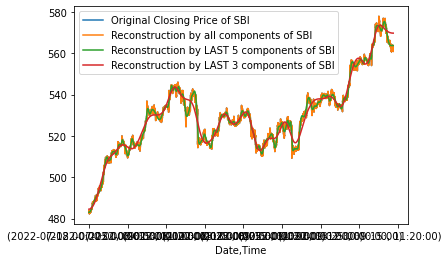



   Plotting of  AXIS BANK



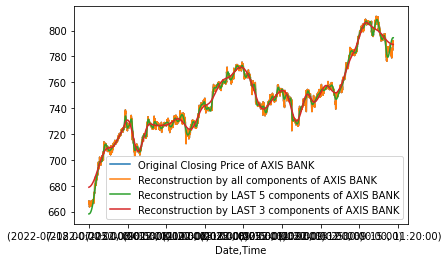



   Plotting of  HDFC BANK



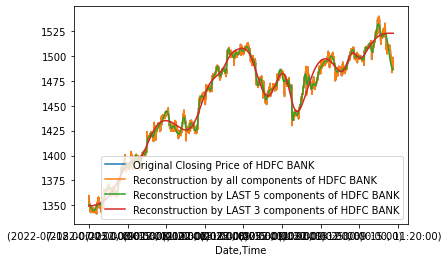



   Plotting of  ICICI BANK



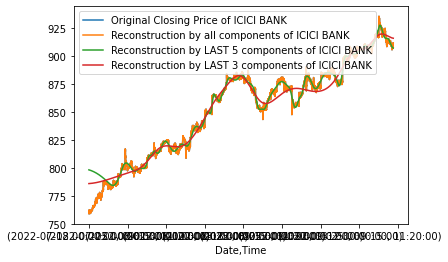



 Plotting the IMFs


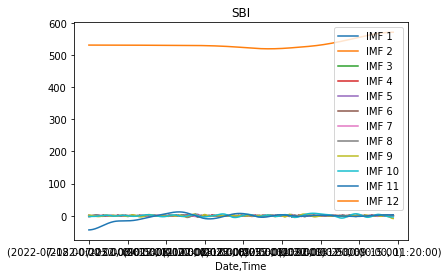

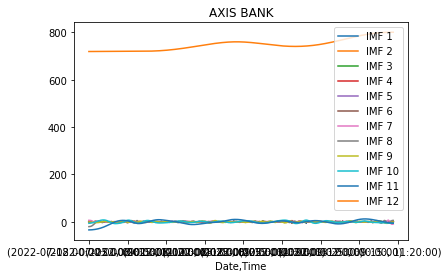

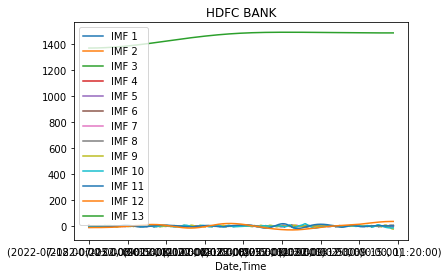

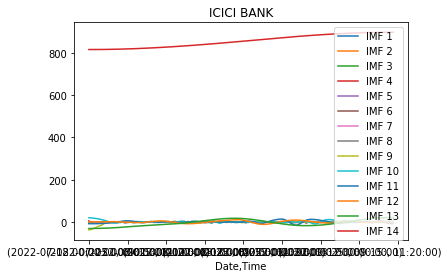




 Plotting IFs & IAs of the IMFs---->





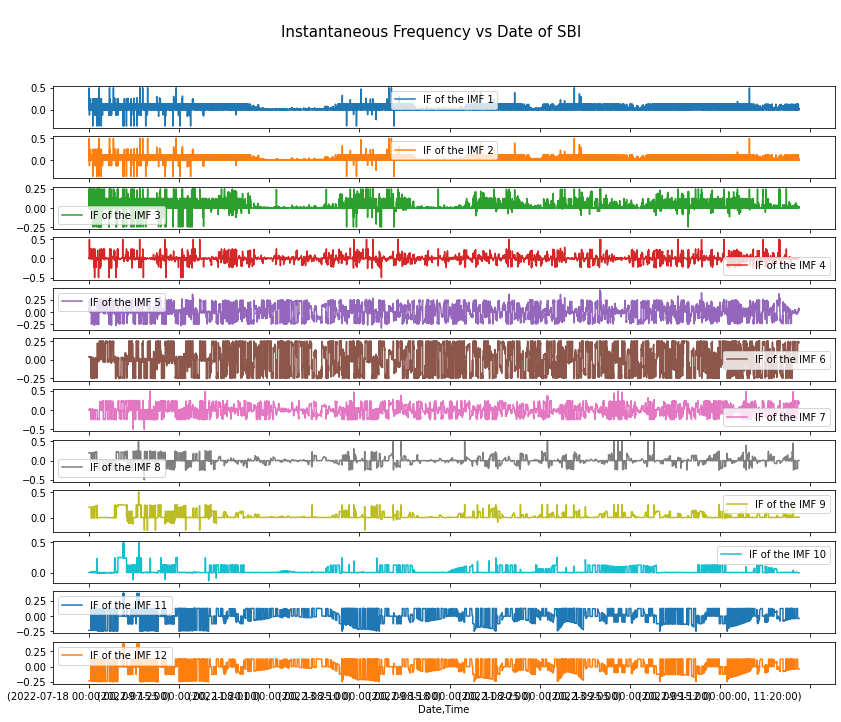

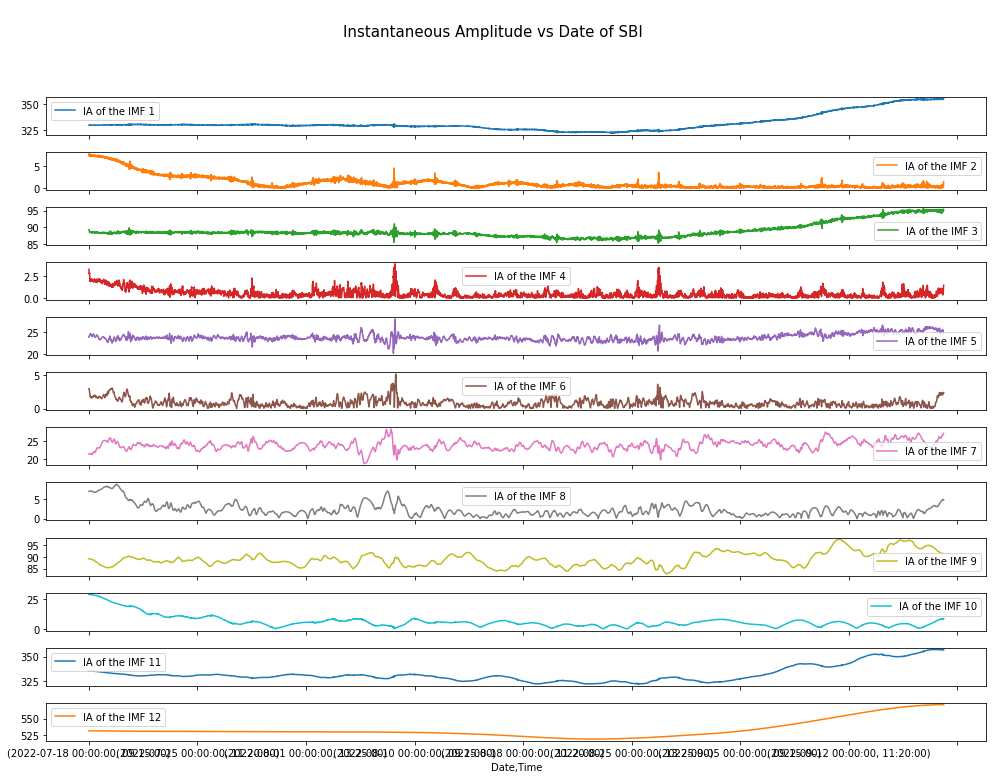

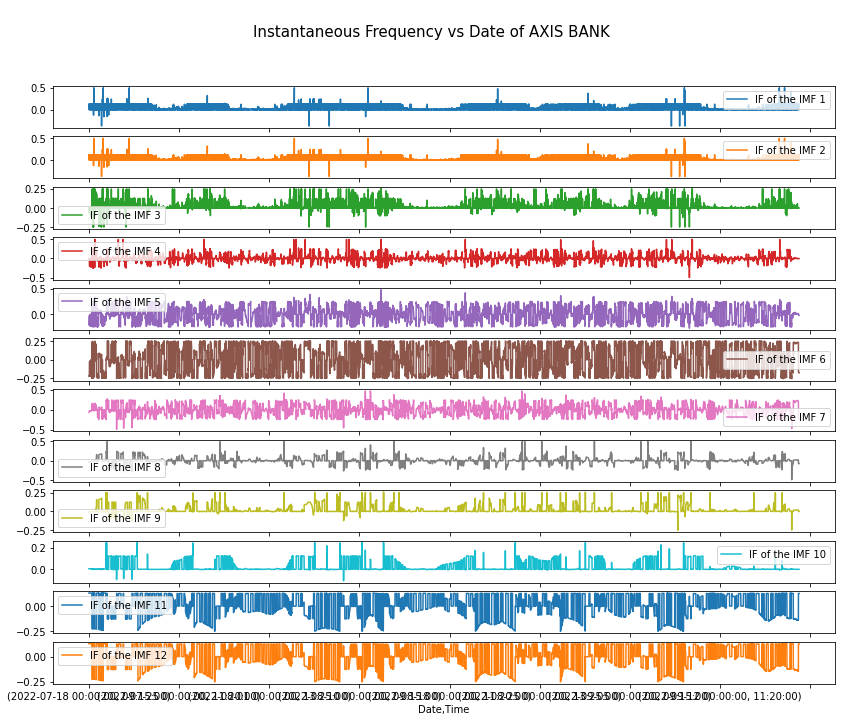

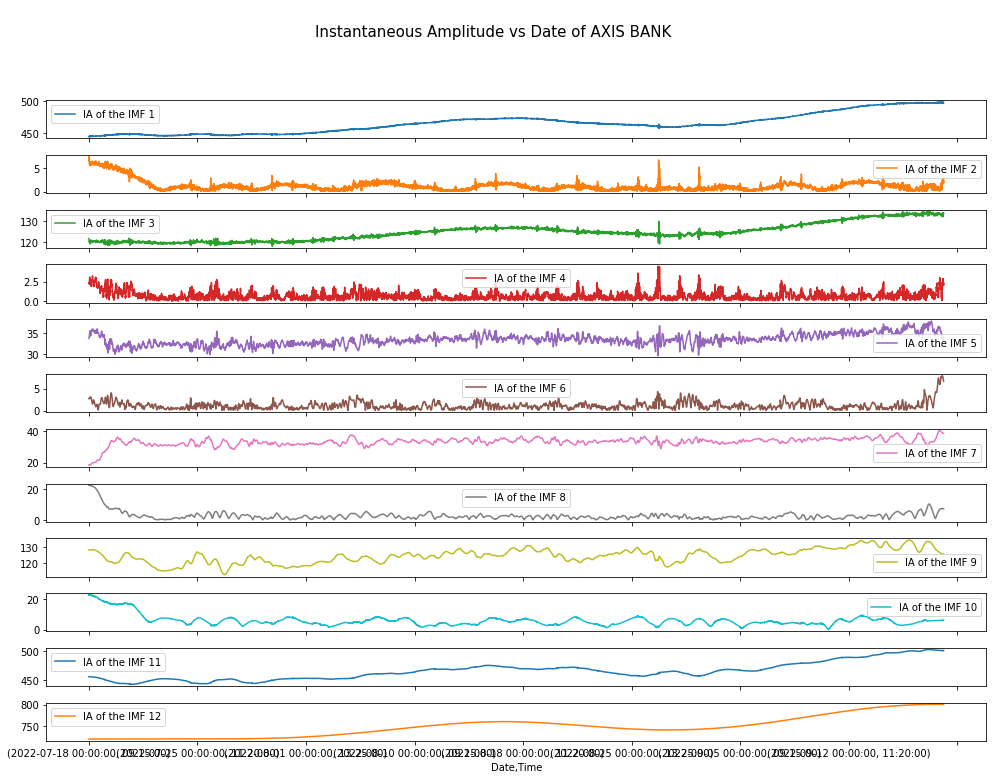

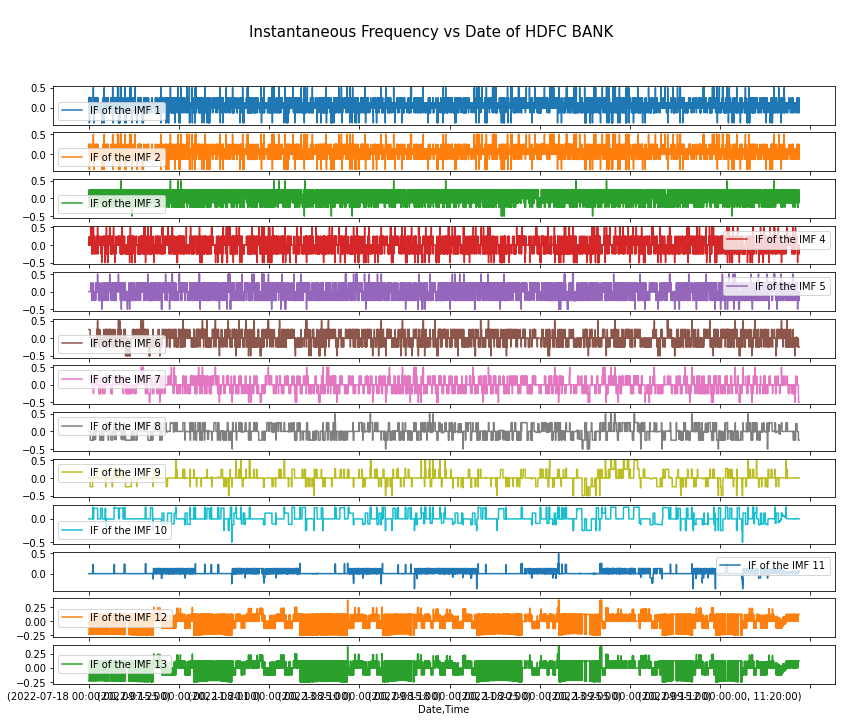

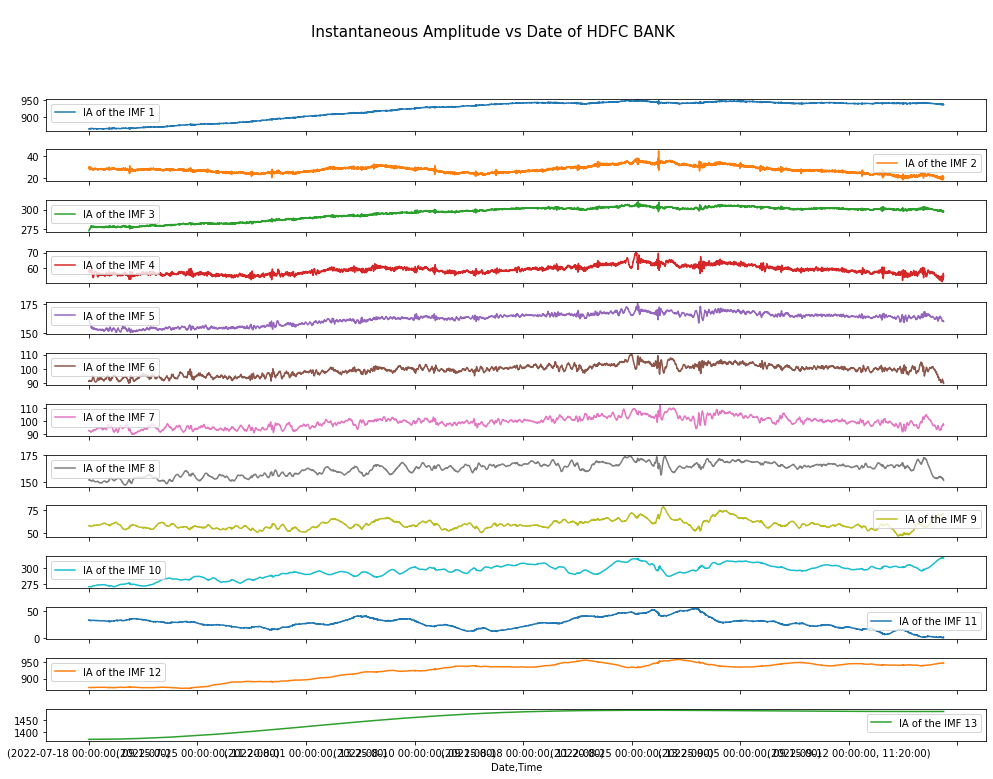

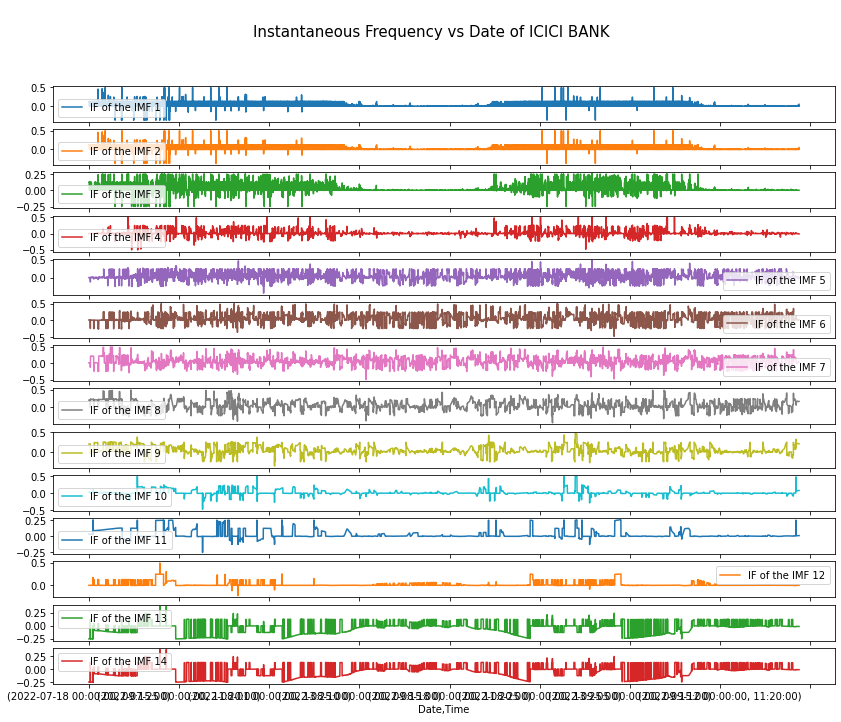

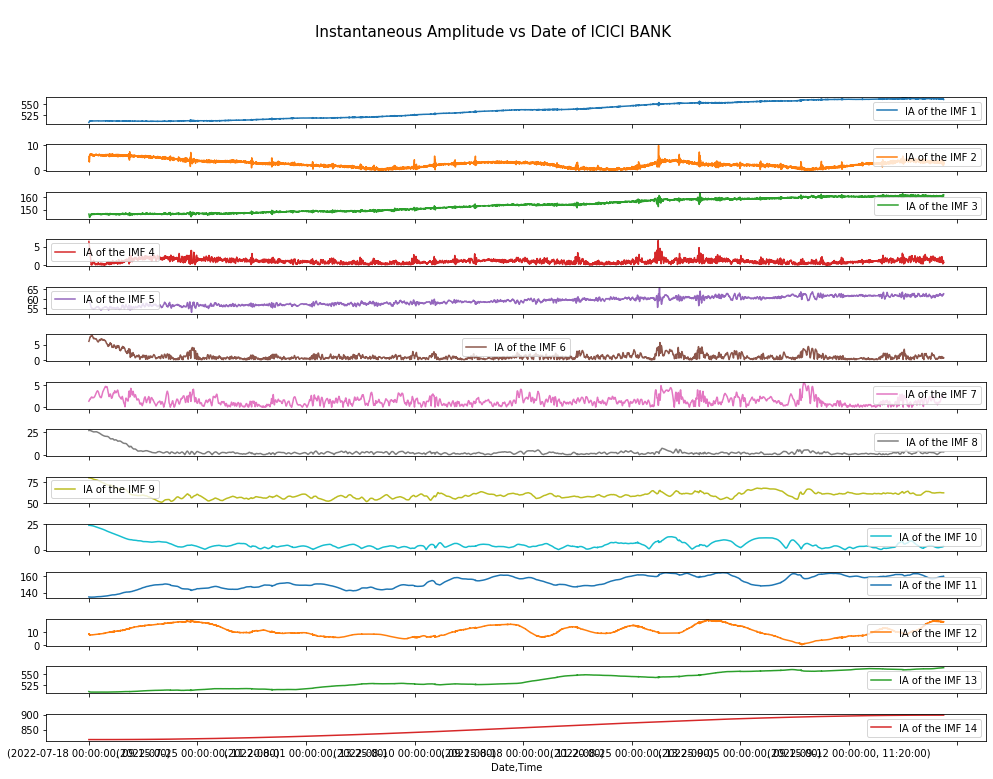



Instantaneous Energy - Frequency Spectrum & Mean of the clusters:::--> 



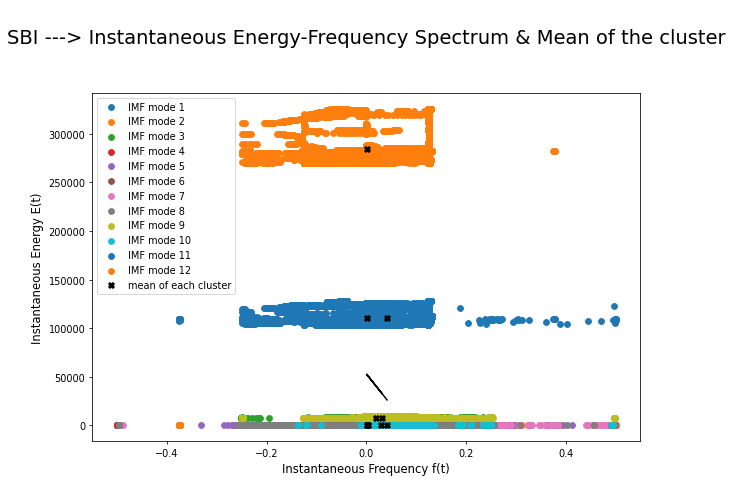

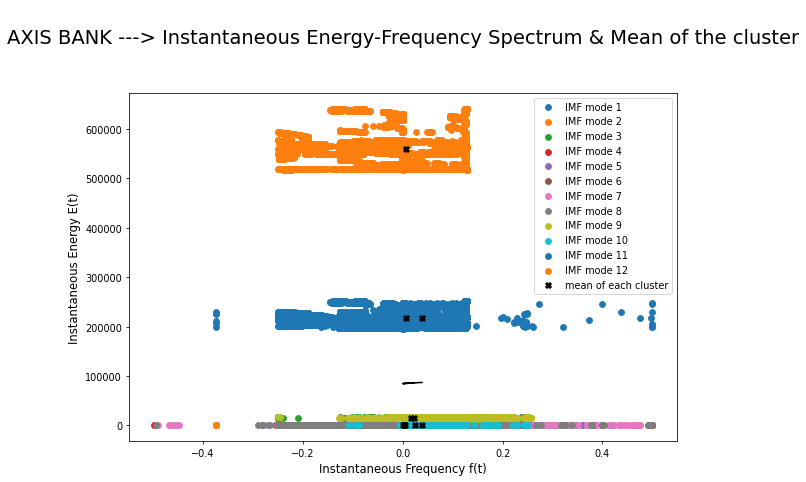

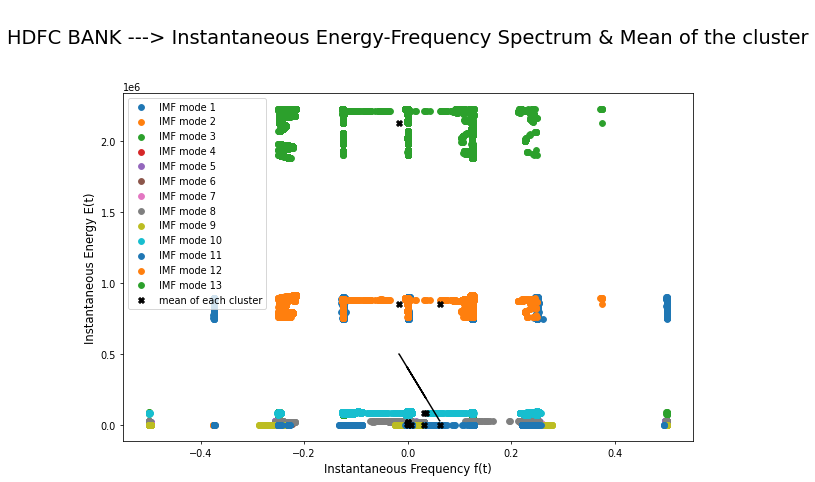

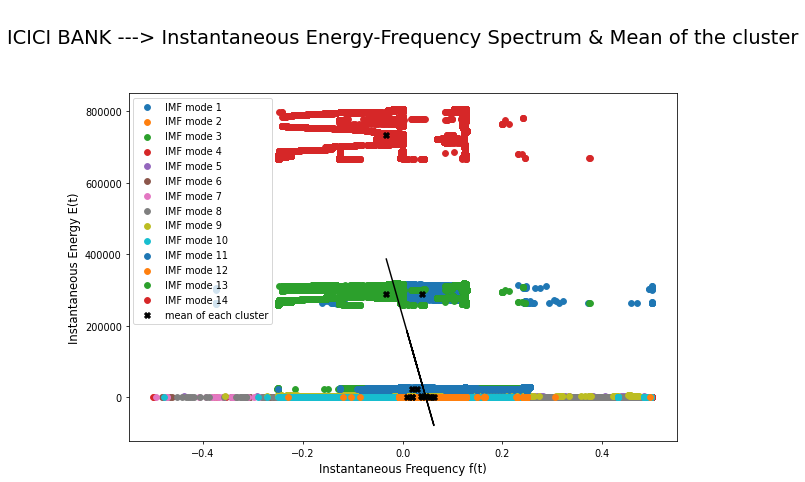



for only IMFs as features -> 

                        IMF 1     IMF 2     IMF 3     IMF 4     IMF 5  \
Date       Time                                                         
2022-07-18 09:15:00 -0.088470  0.364426 -0.240547 -0.956700  1.641141   
           09:16:00  0.152115  0.259909 -0.240343 -0.923866  1.621459   
           09:17:00 -0.143676  0.043385 -0.188189 -0.889253  1.596200   
           09:18:00 -0.084177 -0.030581 -0.083018 -0.850133  1.565348   
           09:19:00  0.119934  0.014626  0.055779 -0.803029  1.528886   
...                       ...       ...       ...       ...       ...   
2022-09-06 12:55:00 -0.022108 -0.065471  0.284960  0.133473  0.023283   
           12:56:00  0.059854  0.027122  0.261135  0.200414  0.027405   
           12:57:00  0.030484  0.091810  0.202767  0.243764  0.030097   
           12:58:00 -0.094344  0.075004  0.145930  0.265503  0.031007   
           12:59:00  0.118191 -0.019267  0.100870  0.268795  0.029815   

                 

ConversionError: Failed to convert value(s) to axis units: array([(Timestamp('2022-07-18 00:00:00'), datetime.time(9, 15)),
       (Timestamp('2022-07-18 00:00:00'), datetime.time(9, 16)),
       (Timestamp('2022-07-18 00:00:00'), datetime.time(9, 17)), ...,
       (Timestamp('2022-09-06 00:00:00'), datetime.time(12, 57)),
       (Timestamp('2022-09-06 00:00:00'), datetime.time(12, 58)),
       (Timestamp('2022-09-06 00:00:00'), datetime.time(12, 59))],
      dtype=object)

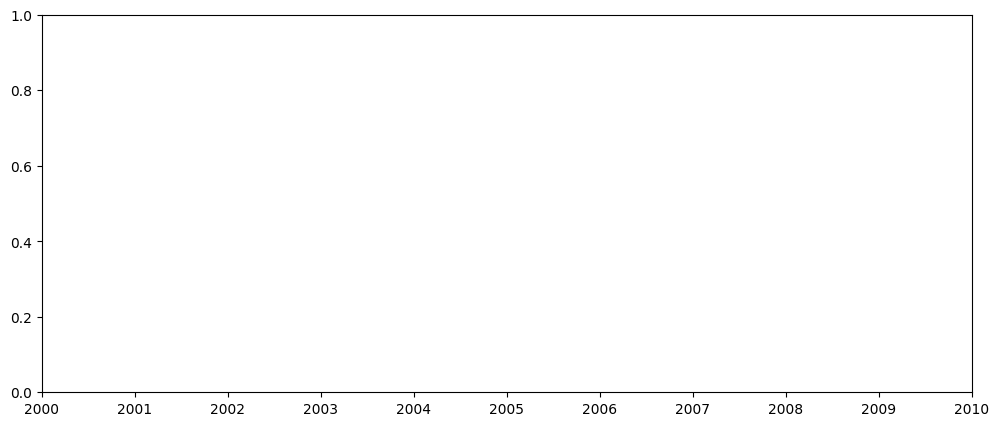

In [24]:
final_byEMD()

# Out-of-time 

In [ ]:
# 5, 2, 2 -> Build_model
model_f522 = ARIMA(train , order=(5,2,2))
fit522 = model_f522.fit()
print(fit522.summary())

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fit522.forecast(20, alpha=0.05) , label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

###  ACTUAL Just NEXT Value:

#### 0n 19-09-2022 at 9:15 A.M.

SBIN -> 568.55

AXIS BANK -> 799.55

HDFC BANK -> 1506.65

ICICI BANK -> 909.50

In [15]:
actual_just_next_val_list = []
for i in range(n):
    actual_just_next_val = input('\nEnter the just Next value (original) of {}: '.format(stock_names_list[i]))
    actual_just_next_val_list.append(actual_just_next_val)
    
for i in actual_just_next_val_list:
    print(i)


Enter the just Next value (original) of SBI: 568.55

Enter the just Next value (original) of AXIS BANK: 799.55

Enter the just Next value (original) of HDFC BANK: 1506.65

Enter the just Next value (original) of ICICI BANK: 909.50
568.55
799.55
1506.65
909.50


In [72]:
list_EMD_feature_set = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA' , 'Original NEXT value' ]

In [31]:
df_next_IMF_SVR_ori = df_next_IMF_SVR_ori.apply(pd.to_numeric) # to convert all columns values into numeric values

list_acc_f1=[]
list_acc_f2=[]
list_acc_f3=[]
list_acc_f4=[]
list_acc_f5=[]
list_acc_f6=[]

for i in range(n):
    # for features - IMFs
    ori_f1 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f1 = df_next_IMF_SVR_ori.iloc[0:1].iloc[0].iloc[i]
    acc_f1 = (1 - (abs(ori_f1 - pred_f1)/ori_f1))*100
    list_acc_f1.append(acc_f1)
    
    #for features - IMFs, hil(IMFs)
    ori_f2 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f2 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
    acc_f2 = (1 - (abs(ori_f2 - pred_f2)/ori_f2))*100
    list_acc_f2.append(acc_f2)
    
    #for features - IMFs, IFs
    ori_f3 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f3 = df_next_IMF_SVR_ori.iloc[2:3].iloc[0].iloc[i]
    acc_f3 = (1 - (abs(ori_f3 - pred_f3)/ori_f3))*100
    list_acc_f3.append(acc_f3)
    
    #for features - IMFs, IAs
    ori_f4 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f4 = df_next_IMF_SVR_ori.iloc[3:4].iloc[0].iloc[i]
    acc_f4 = (1 - (abs(ori_f4 - pred_f4)/ori_f4))*100
    list_acc_f4.append(acc_f4)
    
    #for features - IMFs, IFs, IAs
    ori_f5 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f5 = df_next_IMF_SVR_ori.iloc[4:5].iloc[0].iloc[i]
    acc_f5 = (1 - (abs(ori_f5 - pred_f5)/ori_f5))*100
    list_acc_f5.append(acc_f5)
    
    #for features - IMFs, hil(IMFs), IFs, IAs
    ori_f6 = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i]
    pred_f6 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
    acc_f6 = (1 - (abs(ori_f6 - pred_f6)/ori_f6))*100
    list_acc_f6.append(acc_f6)

In [75]:
df_EMD_SVR_acc = pd.DataFrame(data = [list_acc_f1 , list_acc_f2 , list_acc_f3 , list_acc_f4 , list_acc_f5 , list_acc_f6] , index = ['IMF' , 'IMF-hil(IMF)' , 'IMF-IF' , 'IMF-IA' , 'IMF-IF-IA' , 'IMF-hil(IMF)-IF-IA'] , columns = [stock_names_list])
df_EMD_SVR_acc

,SBI,AXIS BANK,HDFC BANK,ICICI BANK
IMF,97.330238,97.745593,97.894541,98.147932
IMF-hil(IMF),97.303326,97.986457,97.797893,97.732318
IMF-IF,97.211317,97.648653,97.878472,98.040996
IMF-IA,97.303326,97.986457,97.797893,97.732318
IMF-IF-IA,97.147315,97.816494,97.768722,97.581015
IMF-hil(IMF)-IF-IA,97.303326,97.986457,97.797893,97.732318


In [37]:
print('\nJust the Next price:-\n',df_next_IMF_SVR_ori)
print('\n\n\nAbsolute Accuracy (b/w just the next price & the original price) :-\n',df_EMD_SVR_acc)


Just the Next price:-
                             SBI   AXIS BANK    HDFC BANK  ICICI BANK
IMF                  553.371066  781.524891  1474.928101  892.655439
IMF-hil(IMF)         553.218061  783.450715  1473.471961  888.875435
IMF-IF               552.694946  780.749805  1474.685996  891.682861
IMF-IA               553.218061  783.450715  1473.471961  888.875435
IMF-IF-IA            552.331059  782.091777  1473.032444  887.499332
IMF-hil(IMF)-IF-IA   552.402017  783.015438  1472.825685  886.931047
Original NEXT value      568.55      799.55      1506.65      909.50



Absolute Accuracy (b/w just the next price & the original price) :-
                           SBI  AXIS BANK  HDFC BANK ICICI BANK
IMF                 97.330238  97.745593  97.894541  98.147932
IMF-hil(IMF)        97.303326  97.986457  97.797893  97.732318
IMF-IF              97.211317  97.648653  97.878472  98.040996
IMF-IA              97.303326  97.986457  97.797893  97.732318
IMF-IF-IA           97.147315  97.816

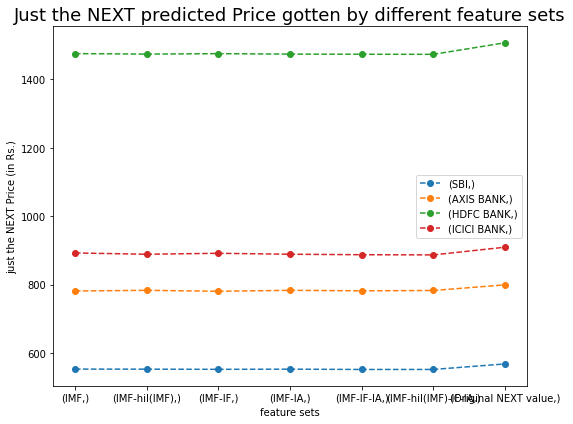

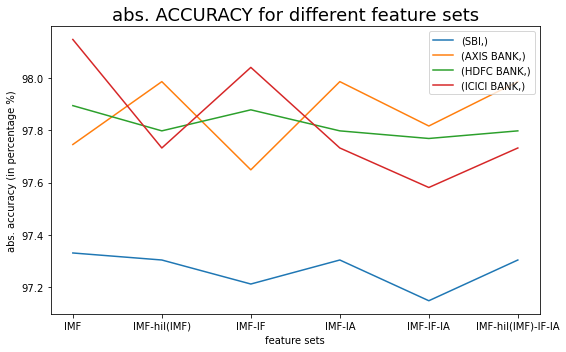

In [67]:
df_next_IMF_SVR_ori = df_next_IMF_SVR_ori.apply(pd.to_numeric) # convert dataframe values to numeric


df_next_IMF_SVR_ori.plot(figsize=(8,6),marker='o',linestyle='dashed')
plt.title('Just the NEXT predicted Price gotten by different feature sets' , fontsize=18)
plt.xlabel('feature sets')
plt.ylabel('just the NEXT Price (in Rs.)')
plt.legend(loc='best')
plt.show()


df_EMD_SVR_acc.plot(figsize=(8,5))
plt.title('abs. ACCURACY for different feature sets' , fontsize=18)
plt.xlabel('feature sets')
plt.ylabel('abs. accuracy (in percentage %)')
plt.legend()
plt.show()

df_next_IMF_SVR = df_next_IMF_SVR_ori.T
df_next_IMF_SVR

In [34]:
df_next_IMF_DTR_ori = pd.DataFrame( data = [ list_next_IMF_DTR , list_next_IMF_hil_DTR , list_next_IMF_IF_DTR , list_next_IMF_IA_DTR , list_next_IMF_IF_IA_DTR , list_next_IMF_hil_IF_IA_DTR , actual_just_next_val_list ] , index = [list_EMD_feature_set] , columns =[stock_names_list]  )

df_next_IMF_DTR_ori

,SBI,AXIS BANK,HDFC BANK,ICICI BANK
IMF,561.5,788.4,1497.65,910.25
IMF-hil(IMF),561.5,788.35,1497.65,910.6
IMF-IF,561.5,788.35,1497.65,910.25
IMF-IA,561.5,788.35,1497.65,910.6
IMF-IF-IA,561.5,788.35,1497.65,910.25
IMF-hil(IMF)-IF-IA,561.5,788.35,1497.65,910.25
Original NEXT value,568.55,799.55,1506.65,909.50


df_next_IMF_DTR = df_next_IMF_DTR_ori.T
df_next_IMF_DTR

In [ ]:
df_next_IMF_DTR_ori = df_next_IMF_DTR_ori.apply(pd.to_numeric) # to convert all columns values into numeric values

svr_list_acc_f1=[]
svr_list_acc_f2=[]
svr_list_acc_f3=[]
svr_list_acc_f4=[]
svr_list_acc_f5=[]
svr_list_acc_f6=[]

for i in range(n):
    
    ori_svr = df_next_IMF_SVR_ori.iloc[6:7].iloc[0].iloc[i] # for original prices of SBI -> AXIS -> ...
    
    # for features - IMFs
    svr_pred_f1 = df_next_IMF_SVR_ori.iloc[0:1].iloc[0].iloc[i]
    svr_acc_f1 = (1 - (abs(ori_svr - svr_pred_f1)/ori_svr))*100
    svr_list_acc_f1.append(svr_acc_f1)
    
    #for features - IMFs, hil(IMFs)
    svr_pred_f2 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
    svr_acc_f2 = (1 - (abs(ori_svr - svr_pred_f2)/ori_svr))*100
    svr_list_acc_f2.append(svr_acc_f2)
    
    #for features - IMFs, IFs
    svr_pred_f3 = df_next_IMF_SVR_ori.iloc[2:3].iloc[0].iloc[i]
    svr_acc_f3 = (1 - (abs(ori_svr - svr_pred_f3)/ori_svr))*100
    svr_list_acc_f3.append(svr_acc_f3)
    
    #for features - IMFs, IAs
    svr_pred_f4 = df_next_IMF_SVR_ori.iloc[3:4].iloc[0].iloc[i]
    svr_acc_f4 = (1 - (abs(ori_svr - svr_pred_f4)/ori_svr))*100
    svr_list_acc_f4.append(svr_acc_f4)
    
    #for features - IMFs, IFs, IAs
    svr_pred_f5 = df_next_IMF_SVR_ori.iloc[4:5].iloc[0].iloc[i]
    svr_acc_f5 = (1 - (abs(ori_svr - svr_pred_f5)/ori_svr))*100
    svr_list_acc_f5.append(svr_acc_f5)
    
    #for features - IMFs, hil(IMFs), IFs, IAs
    svr_pred_f6 = df_next_IMF_SVR_ori.iloc[1:2].iloc[0].iloc[i]
    svr_acc_f6 = (1 - (abs(ori_svr - svr_pred_f6)/ori_svr))*100
    svr_list_acc_f6.append(svr_acc_f6)